In [1]:
# https://drive.google.com/open?id=1ngv0KTuqCOIxUJ-62vHXzvqrzmre6hw-
import glob
import pandas as pd
df = pd.DataFrame(columns=["path", "target"])
for path in glob.glob("train/cat.*.jpg"):
    s = pd.Series([path, 0], index=["path", "target"])
    df = df.append(s, ignore_index=True)
for path in glob.glob("train/dog.*.jpg"):
    s = pd.Series([path, 1], index=["path", "target"])
    df = df.append(s, ignore_index=True)
df

,path,target
0,train\cat.0.jpg,0
1,train\cat.1.jpg,0
2,train\cat.10.jpg,0
3,train\cat.100.jpg,0
4,train\cat.1000.jpg,0
5,train\cat.10000.jpg,0
6,train\cat.10001.jpg,0
7,train\cat.10002.jpg,0
8,train\cat.10003.jpg,0
9,train\cat.10004.jpg,0


Using TensorFlow backend.


Size: (500, 374)


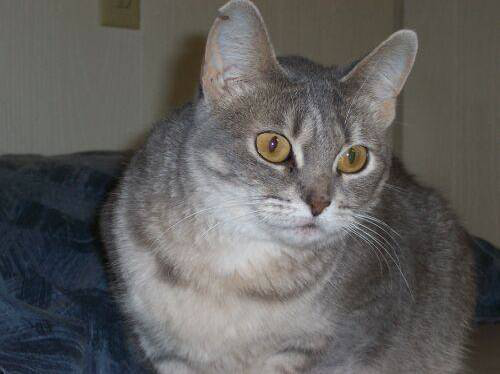

In [2]:
from keras.preprocessing.image import load_img
import random
import matplotlib.pyplot as plt
%matplotlib inline
c = random.randint(0, 24999)
img = load_img(df.iloc[c]["path"])
print("Size:", img.size)
img

Size: (224, 224)


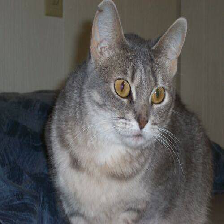

In [3]:
img = load_img(df.iloc[c]["path"], target_size=(224, 224))
print("Size:", img.size)
img

In [4]:
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Flatten, Dense, BatchNormalization
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
vgg = VGG16(include_top=False, input_shape=(224, 224, 3))
# 眼睛不訓練
for l in vgg.layers:
    l.trainable = False
# x = f(vgg.output)
x = Flatten()(vgg.output)
# [ADD]
x = BatchNormalization()(x)
# x = f2(x)
x = Dense(units=2048, activation="relu")(x)
x = Dense(units=256, activation="relu")(x)
x = Dense(units=2, activation="softmax")(x)
model = Model(inputs=vgg.input, outputs=x)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [5]:
model.compile(loss="categorical_crossentropy", 
              optimizer="adam",
              metrics=["accuracy"])

In [6]:
from sklearn.model_selection import train_test_split
# 為了簡單不出錯, 把所有的群集轉成numpy的array
import numpy as np
x_train, x_test, y_train, y_test = train_test_split(np.array(df["path"]),
                                                    np.array(df["target"]),
                                                    test_size=0.1)
# 因為圖片還沒載入, 所以我先只作y的預處理(One-hot)
from keras.utils import np_utils
y_train_cat = np_utils.to_categorical(y_train)
y_test_cat = np_utils.to_categorical(y_test)

VGG16論文: 圖片(RGB) -> BGR -> 減去資料集像素平均(B - 103.939, G - 116.779, R - 123.68)

In [7]:
# 偷誰的模型 就偷它的預處理方式
from keras.applications.vgg16 import preprocess_input
preprocess_input(np.array(img))

array([[[  -8.939003,  -17.779   ,  -23.68    ],
        [  -7.939003,  -16.779   ,  -22.68    ],
        [  -6.939003,  -15.778999,  -21.68    ],
        ...,
        [ -34.939003,  -38.779   ,  -41.68    ],
        [ -35.939003,  -39.779   ,  -42.68    ],
        [ -35.939003,  -39.779   ,  -42.68    ]],

       [[  -8.939003,  -17.779   ,  -23.68    ],
        [  -7.939003,  -16.779   ,  -22.68    ],
        [  -6.939003,  -15.778999,  -21.68    ],
        ...,
        [ -34.939003,  -38.779   ,  -41.68    ],
        [ -35.939003,  -39.779   ,  -42.68    ],
        [ -35.939003,  -39.779   ,  -42.68    ]],

       [[  -8.939003,  -17.779   ,  -23.68    ],
        [  -7.939003,  -16.779   ,  -22.68    ],
        [  -6.939003,  -15.778999,  -21.68    ],
        ...,
        [ -34.939003,  -38.779   ,  -41.68    ],
        [ -35.939003,  -39.779   ,  -42.68    ],
        [ -35.939003,  -39.779   ,  -42.68    ]],

       ...,

       [[ -17.939003,  -42.779   ,  -59.68    ],
        [  

In [10]:
batch = 20
for i in range(5):
    c = np.random.randint(0, x_train.shape[0], size=batch)
    # print(i, x_train[c])
    # print(i, y_train[c])
    imglist = []
    for path in x_train[c]:
        img = load_img(path, target_size=(224, 224))
        img_pre = preprocess_input(np.array(img))
        imglist.append(img_pre)
    imglist = np.array(imglist)
    targets = y_train_cat[c]
    result = model.train_on_batch(imglist, targets)
    print(i, "[loss, accuracy]", result)
        

0 [loss, accuracy] [1.6005656, 0.8]
1 [loss, accuracy] [4.91084e-05, 1.0]
2 [loss, accuracy] [0.26109725, 0.95]
3 [loss, accuracy] [0.53195834, 0.95]
4 [loss, accuracy] [0.00018448863, 1.0]


In [11]:
test = 100
c = np.random.randint(0, x_test.shape[0], size=test)
# print(i, x_train[c])
# print(i, y_train[c])
imglist = []
for path in x_test[c]:
    img = load_img(path, target_size=(224, 224))
    img_pre = preprocess_input(np.array(img))
    imglist.append(img_pre)
imglist = np.array(imglist)
targets = y_test_cat[c]
model.evaluate(imglist, targets)

100/100 [==============================] - 35s 348ms/step


[1.6013083012969582, 0.87]